# Notebook for tICA RC plotting.
This notebook plots ground-truth MD trajectories and Boltz \
'trajectories' (either real Langevin trajectories or inference runs \
stitched together into a 'trajectory') on tICA RCs for visualization.

Requires:
- Pre-computed tICA eigenvectors and means (.npy)
- Ground-truth trajectory (hdf5) and topology (pdb)
- Boltz 'trajectory' and topology (pdb)
    - For a Langevin trajectory, an hdf5
    - For inference samples, a path to the inference result directory


## Imports and preliminaries

In [2]:
import h5py
import mdtraj as md
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
from tqdm import tqdm

from openmm.app import *
from openmm import *
from simtk.unit import *

a_to_nm = 0.1

In [3]:
# Helper functions
def get_reaction_coordinates(
    top, 
    r_coordinates,
    mean, 
    eigenvectors,
    device="cuda:0"
):
    """Computes tICA RC values of each frame in a trajectory.

    Parameters
    ----------
    top : mdtraj.Topology object
        Topology of the trajectory.

    r_coordinates : np.array of shape (frames, n_atoms, 3)
        Coordinate array of the trajectory.

    Returns
    -------
    all_projections_sub : torch.tensor of shape (frames, 2)
        tICA coordinate values for every frame.
    """
    traj = md.Trajectory(r_coordinates, top).atom_slice(top.select("name CA"))
    distance_indeces = [[i, j] for i in range(traj.n_atoms) 
                    for j in range(i + 1, traj.n_atoms)]
    all_distances = md.compute_distances(traj, distance_indeces)
    all_projections_sub = ((all_distances - mean)  @ eigenvectors)[:, :2]
    return torch.tensor(all_projections_sub)

## Loading in necessary files for plotting.

### Loading in pre-defined tICA coordinates.

In [4]:
# Loading tICA coordinates computed using the GT trajectory.
EIGENS_PATH = "/data2/scratch/group_scratch/cg/datasets/chignolin/tica_eigenvectors.npy"
MEANS_PATH = "/data2/scratch/group_scratch/cg/datasets/chignolin/tica_mean.npy"

tica_eigenvectors = np.load(EIGENS_PATH)
tica_means = np.load(MEANS_PATH)

### Loading in ground-truth trajectory and topology.

In [5]:
GT_TOP_PATH = '/data2/scratch/group_scratch/cg/datasets/chignolin/chignolin.pdb'
GT_TRAJ_PATH = '/data2/scratch/group_scratch/cg/datasets/chignolin/chignolin_traj_all.hdf5'

gt_topology = md.load(GT_TOP_PATH).topology

with h5py.File(GT_TRAJ_PATH, 'r') as file:
    if "positions" not in file.keys():
        raise ValueError("No positions in file")
    positions = file["positions"][:]
    frames_to_save = np.arange(positions.shape[0])
    gt_trajectory = md.Trajectory(
        positions * a_to_nm, # Ground truth positions are in angstroms.
        gt_topology
    )

### Creating Boltz trajectories.

#### Using inference samples to stitch a 'trajectory' together.

In [6]:
# PRED_DIR = '/home/ethanz/boltz-likelihoods/boltz_results_chignolin_highT/predictions/chignolin_highT'

# pred_structs = [
#     os.path.join(PRED_DIR, file) for file in os.listdir(PRED_DIR)
#     if file[-4:] == '.cif'
#     ]

# traj_coordinates = []
# for file in tqdm(sorted(pred_structs)):
#     temp = md.load(os.path.join(PRED_DIR, file)) # cifs are in angstroms.
#     traj_coordinates.append(temp.xyz) # These are all now in nanometers! No more conversion needed.

# traj_coordinates = np.array(traj_coordinates).squeeze(1) # (n_preds, n_atoms, 3) 
# boltz_topology = md.load(pred_structs[0]).topology
# boltz_trajectory = md.Trajectory(traj_coordinates, boltz_topology)

# final_trajs = [boltz_trajectory]

#### Loading a Boltz Langevin trajectory.

In [7]:
LANGEVIN_OUT = '/home/ethanz/boltz-likelihoods/boltz_results_chignolin_langevin_leps1e-6_lnoise1.0_stop198/trajectories/chignolin/traj_and_scores.h5'
boltz_top_file = '/home/ethanz/boltz-likelihoods/boltz_results_chignolin_langevin_leps1e-6_lnoise1.0_stop198/predictions/chignolin/chignolin_model_0.pdb'

final_trajs = []
with h5py.File(LANGEVIN_OUT, 'r') as file:
    if "traj" not in file.keys():
        raise ValueError("No trajectory data in file")
    boltz_trajs = file["traj"][:]
    print(boltz_trajs.shape) # (n_steps, n_seeds, n_atoms, 3)
    boltz_trajs = [boltz_trajs[:, i, :, :] for i in range(boltz_trajs.shape[1])]
    print(boltz_trajs[0].shape)

    boltz_topology = md.load(boltz_top_file).topology
    for boltz_traj in boltz_trajs:
        md_traj = md.Trajectory(
            boltz_traj * a_to_nm, # Ground truth positions are in angstroms.
            boltz_topology
        )
        final_trajs.append(md_traj)

(1000000, 5, 92, 3)
(1000000, 92, 3)


In [8]:
# Gut-checking conversions.
print(np.linalg.norm(final_trajs[0].xyz[0][0] - final_trajs[0].xyz[0][1]))
print(np.linalg.norm(gt_trajectory.xyz[0][0] - gt_trajectory.xyz[0][1]))

0.13732353
0.10900013


## Plotting.

(5000000, 2)
torch.Size([1229000, 2])


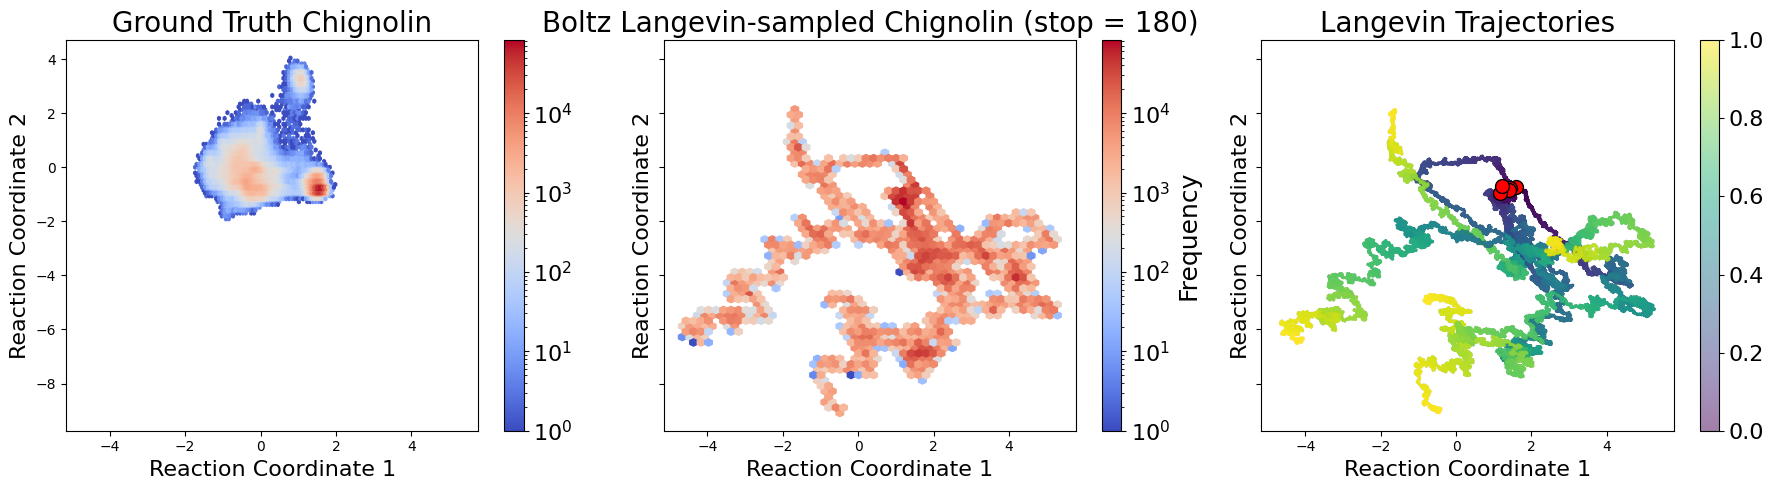

In [9]:
FIG_SAVE_PATH = '/home/ethanz/figs/chignolin_langevin_leps1e-6_lnoise1.0_stop180.jpg'

boltz_rcs = []
for traj in final_trajs:
    temp = get_reaction_coordinates(
        traj.topology, 
        traj.xyz,
        tica_means,
        tica_eigenvectors,
        device="cuda:0")
    boltz_rcs.append(temp)
boltz_rcs_concatenated = np.concatenate(boltz_rcs, axis=0)
print(boltz_rcs_concatenated.shape)

gt_rcs = get_reaction_coordinates(
    gt_trajectory.topology, 
    gt_trajectory.xyz,
    tica_means,
    tica_eigenvectors,
    device="cuda:0")
print(gt_rcs.shape)

fig, ax = plt.subplots(1,3, figsize=(18, 5), sharex=True, sharey=True)

hb = ax[0].hexbin(gt_rcs[:,0], gt_rcs[:,1], gridsize=50, cmap='coolwarm', norm=mcolors.LogNorm())
ax[0].set_title("Ground Truth Chignolin", fontsize=20)
ax[0].set_xlabel("Reaction Coordinate 1", fontsize=16)
ax[0].set_ylabel("Reaction Coordinate 2", fontsize=16)

hb = ax[1].hexbin(boltz_rcs_concatenated[:,0], boltz_rcs_concatenated[:,1], gridsize=50, cmap='coolwarm', norm=mcolors.LogNorm())
ax[1].set_title("Boltz Langevin-sampled Chignolin (stop = 180)", fontsize=20)
ax[1].set_xlabel("Reaction Coordinate 1", fontsize=16)
ax[1].set_ylabel("Reaction Coordinate 2", fontsize=16)

# Plotting trajectories. May want to skip if using inference samples instead of Langevin.
for rc in boltz_rcs:
    x = rc[:, 0]
    y = rc[:, 1]

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(
        segments,
        cmap='viridis',
        norm=plt.Normalize(0, 1),
        linewidth=2,
        alpha=0.5
    )

    lc.set_array(np.linspace(0, 1, len(x)-1))
    ax[2].add_collection(lc)

    ax[2].scatter(
        x[0], y[0],
        color='red',
        s=100, 
        marker='o',
        edgecolor='black',
        zorder=5,
        label='Start'
    )
    
ax[2].set_title('Langevin Trajectories', fontsize=20)
ax[2].set_xlabel('Reaction Coordinate 1', fontsize=16)
ax[2].set_ylabel('Reaction Coordinate 2', fontsize=16)

# Add colorbars to all axes.
cb = fig.colorbar(hb, ax=ax[0])
cb.ax.tick_params(labelsize=16)
cb = fig.colorbar(hb, ax=ax[1])
cb.ax.tick_params(labelsize=16)
cb.set_label('Frequency', fontsize=18) 
cb = fig.colorbar(lc, ax=ax[2])
cb.ax.tick_params(labelsize=16)

# plt.savefig(FIG_SAVE_PATH)
plt.tight_layout()
plt.show()

## Miscellaneous

In [10]:
# Saving trajectories for viewing.
SAVE_DIR = '/home/ethanz/figs'

traj_to_save = final_trajs[0]
n_frames = traj_to_save.n_frames
indices = np.linspace(0, n_frames - 1, 1000, dtype=int)

sparse_traj = traj_to_save[indices].center_coordinates()

save_path = os.path.join(SAVE_DIR, 'chignolin_1e-6_stop198.cif')
sparse_traj.save(save_path)